# Learning Bioinformatics in Python
Author: Dylan Loader

# Introduction

**Disclaimer**: To be completely transparent, I am not a Biologist, Bioinformatician, or Chemist of any kind. The last Biology course I took was in Winter 2014. There will  be places where I make gross over generalizations and if you find yourself saying:

<img src="correction.png" width="200">

Please contact me and correct me so this tutorial doesn't misguide anyone, no problem is too small to contact me about. My email is dylanloader@gmail.com.


## Motivation

This project will be an open exporation into the world of Bioinformatics (BI) for use in my project for MDSC 401 and STAT 641 at the University of Calgary. MDSC401 is Introduction to Bioinformatics, which covers an array of topics from Sequence Alignment to Markov Models. STAT543 is Statistical Learning, and is focused on understanding the fundamentals in Machine Learning techniques from a Statistical background. 

I am purposely choosing some fields here I am weak in to force myself to sink or swim in learning about these topics. Here are the topics:

* Bioinformatics
* Python3
* Machine Learning (Specifically CNNs)
* Jupyter Notebooks


At the current time I have little background in any of this and hope that S-T-ruggling through it will serve as informative, or a warning of sorts to anyone who comes across this. 

# RNA A to I Editing

Primary resource: https://www.youtube.com/channel/UCEPMCywJ6FPZpQ_aPEZt5JA

My project focuses mainly on data from the RNA A-to-I database [REDIportal](http://srv00.recas.ba.infn.it/atlas/).
RNA A-to-I Editing is a useful process in which cells can use a genome of limited size to generate a greater number of proteins. This process has been recorded in both Prokaryotic and Eukaryotic cells. During RNA A-to-I Editing, adenosine is converted to inosine. 

## A crash course in RNA editing

Eukaryotes differ from prokaryotes in that prokaryotes do not have intron and exon regions in their RNA. This has to do with many factors, including the limited size of the chromosome in prokaryotes relative to that of eukaryotes. RNA editing is a method in which cells can utilize the same regions in their RNA to express different proteins. By allowing one genomic region to be modified to allow expressions of several proteins the cell can limit the size of its genome while simultaneously increasing the complexity of its cellular processes. 


## Transposons

Transposons or 'jumping genes' are sequences of DNA that contain the machinery to remove and reinsert themselved in the genome. Since RNA is transcribed from DNA in Eukaryotes we can utilize the aforementioned RNA editing site data to categorize transposons in the DNA of a cell. Transposons are important to understand as they can cause or reverse mutations by interupting genome sequences. 

### ALU Elements

TODO: Add more specific information on ALU elements and contrast them to other transposons.


# Project Python Code

In [1]:
# Import statements
import os
from time import time
from IPython.display import Image
from pysster.Data import Data
from pysster.Grid_Search import Grid_Search
from pysster import utils

# Generate a folder to hold the output
output_folder = "pysster_output/"

# Check to see if the output directory is in our path.
# If it is not, generate the output folder
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)
    
# Make sure tensorflow is installed and that our gpu is accessible
import tensorflow as tf
print("TensorFlow version: "+ tf.__version__)
print("Current GPU used: "+ tf.test.gpu_device_name())
# This should return something like
# TensorFlow version: 1.12.0
# Current GPU used: /device:GPU:0
# If it returns GPU:0, the Jupyter notebook isn't recognizing your GPU.


Using TensorFlow backend.


TensorFlow version: 1.12.0
Current GPU used: /device:GPU:0


In [5]:
# Load datasets of RNA A to I editing

# Import the data using the ACGU alphabet for RNA and HIMS for proteins
data = Data(["data/alu.fa.gz",
             "data/rep.fa.gz",
             "data/nonrep.fa.gz"], ("ACGU", "HIMS")) 

#print(data.get_summary())

Segement the data into training,validation, and test sets.

In [6]:
# Split the data into training/validation/test sets with the relative proportions 0.7/0.15/0.15
# Seed is defined to allow users to replicate numbers
data.train_val_test_split(portion_train=0.7, portion_val=0.15, seed=1775)
print(data.get_summary())

              class_0    class_1    class_2
all data:       50000      50000      50000
training:       34954      35030      35016
validation:      7533       7479       7488
test:            7513       7491       7496


## Model Training and Summary


In [7]:
# Create a set of models to perform the grid search over.
params = {"conv_num": [2, 3], "kernel_num": [20], "kernel_len": [20], "dropout_input": [0.0,0.1, 0.4]}
# Grid search over the set of models. This generates 2x1x1x3 = 6 models and compares them by ROC and AUC
searcher = Grid_Search(params)

# Record the stop and start times to see how long our training takes.
start = time()
model, summary = searcher.train(data, verbose=False)
stop = time()
print("time in minutes: {}".format((stop-start)/60))

time in minutes: 56.974257810910544


In [5]:
print(summary)

# conv_num: [2, 3]
# kernel_num: [20]
# kernel_len: [20]
# dropout_input: [0.0, 0.1, 0.4]
conv_num kernel_num kernel_len dropout_input roc-auc
       3         20         20           0.0 0.96338
       3         20         20           0.1 0.96305
       2         20         20           0.1 0.96168
       2         20         20           0.0 0.96093
       3         20         20           0.4 0.95060
       2         20         20           0.4 0.94320



From the model summary we see that the ROC-AUC is maximized when we use the model with no dropout. Since the ROC-AUC metric in this step is based on the validation data we may find that the out of sample prediction in the test set is poor, suggesting that the model over fits the training and validation sets. Dropping out connections between the layers of our network adds a degree of 'randomness' by disconnecting contiguous nodes in the network, and can often lead to better preditive power overall.

# Evaluation of Model Performance

We first look at the summary to 'visualize' in some sense to see the layers are set up. The dropout layers are still included in the model even though the optimal model was found to not require dropout. 

In [20]:
model.model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 301, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 301, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 282, 20)           6420      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 141, 20)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 141, 20)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 122, 20)           8020      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 20)            0         
__________

In [21]:
test_predictions = model.predict(data,"test")
print("Test Prediction Values")
print(test_predictions)

# Retrieve the labels of the test set
test_labels = data.get_labels("test")
print("Test Labels")
print(test_labels)

Test Prediction Values
[[9.9999988e-01 1.7397952e-07 1.5021381e-10]
 [1.0000000e+00 1.6698840e-08 2.3137559e-09]
 [1.0870082e-06 4.6968386e-01 5.3031504e-01]
 ...
 [7.7151464e-07 1.3938043e-01 8.6061877e-01]
 [8.1121556e-07 1.5919578e-01 8.4080338e-01]
 [1.3452775e-07 2.5460821e-01 7.4539167e-01]]
Test Labels
[[1 0 0]
 [1 0 0]
 [0 0 1]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


             precision    recall  f1-score   roc-auc    pr-auc          n
     class_0     0.979     0.964     0.972     0.998     0.996  |    7513
     class_1     0.908     0.694     0.787     0.939     0.905  |    7491
     class_2     0.763     0.955     0.848     0.949     0.866  |    7496


weighted avg     0.884     0.871     0.869     0.962     0.923  |        




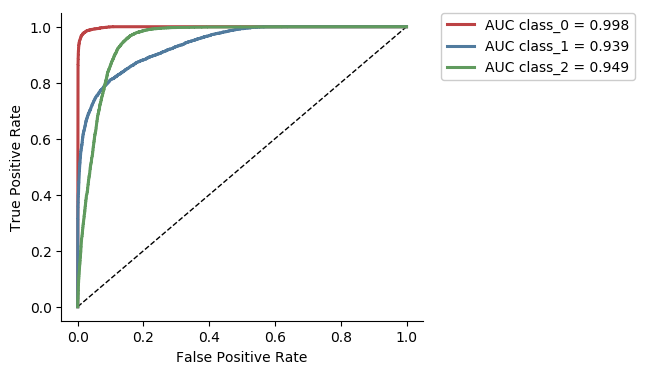

In [22]:
utils.plot_roc(test_labels, test_predictions, output_folder+"roc.png")
utils.plot_prec_recall(test_labels, test_predictions, output_folder+"prec.png")
print(utils.get_performance_report(test_labels, test_predictions))

Image(output_folder+"roc.png")

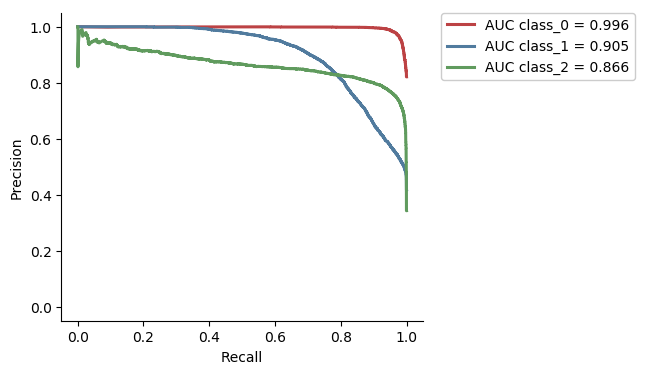

In [23]:
Image(output_folder+"prec.png")

In [24]:
utils.save_data(data, output_folder+"data.pkl")
utils.save_model(model, output_folder+"model.pkl")

# Resources

I will try to keep the resources used up to date and give credit to the fantastic people who dedicate themselves to teaching others in this section.

## Bioinformatics

Introductory Youtube series for BI: https://www.youtube.com/watch?v=UkSLdj_RRps&index=5&list=PL6yVKsUPBjJYXhGPlD8tAOglqefPBy35x

Book for BI: 'Elementary Sequence Analysis' by Brian Golding, Dick Morton and Wilfried Haerty 
http://helix.mcmaster.ca/3S03_2011.pdf

RNA A to I Editing: https://en.wikipedia.org/wiki/RNA_editing


## Python3

Getting tensorflow top recognize my gpu in windows: https://www.pugetsystems.com/labs/hpc/The-Best-Way-to-Install-TensorFlow-with-GPU-Support-on-Windows-10-Without-Installing-CUDA-1187/

It is very important to make sure you install tensorflow-gpu, for some reason Jupyter wouldn't recognize my GPU (RTX2070) using the suggested version of tensorflow.

## Machine Learning

For background information on Machine Learning: "Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems" by Aurélien Géron. It is really a great resource so far and I am hoping Tensorflow V2 is included in the new edition.

## Jupyter Notebooks

For visual styling in Jupyter: https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks

